**调用2B模型**

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
torch.manual_seed(0)

path = 'openbmb/MiniCPM-2B-sft-bf16'
tokenizer = AutoTokenizer.from_pretrained(path)
MiniCPM = AutoModelForCausalLM.from_pretrained(path, torch_dtype=torch.bfloat16, device_map='cuda', trust_remote_code=True)



d:\Anaconda\envs\grad\lib\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: '[WinError 127] 找不到指定的程序。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


**简单测试**

In [2]:
responds, history = MiniCPM.chat(tokenizer, "山东省最高的山是哪座山, 它比黄山高还是矮？差距多少？", temperature=0.8, top_p=0.8)
print(responds)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48


山东省最高的山是泰山，海拔1545米。黄山是中国的著名山脉，位于安徽省，海拔1864米。因此，黄山比泰山高，两者之间的差距为319米。


In [4]:
print(history)

[{'role': 'user', 'content': '山东省最高的山是哪座山, 它比黄山高还是矮？差距多少？'}, {'role': 'assistant', 'content': '山东省最高的山是泰山，海拔1545米。黄山是中国的著名山脉，位于安徽省，海拔1864米。因此，黄山比泰山高，两者之间的差距为319米。'}]


这里返回值有`history`，就不需要我们再单独收集了，我们只需要取到返回值`extend`到`chat_history`列表即可      
然后每次提问丢给模型，模型会根据记忆生成回复

In [7]:
chat_history = []

def chat_with_memory(question):
    response,history = MiniCPM.chat(tokenizer, question, history=chat_history, temperature=0.8, top_p=0.8)
    chat_history.extend(history)
    return response

question1 = "1+1=?"
print(chat_with_memory(question1))
question2 = "我刚刚问了你什么？"
print(chat_with_memory(question2))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


2
作为一个AI语言模型，我没有记忆或浏览互联网的能力，因此无法记住您之前的问题或对话。您能否提供更多上下文或澄清您的问题？


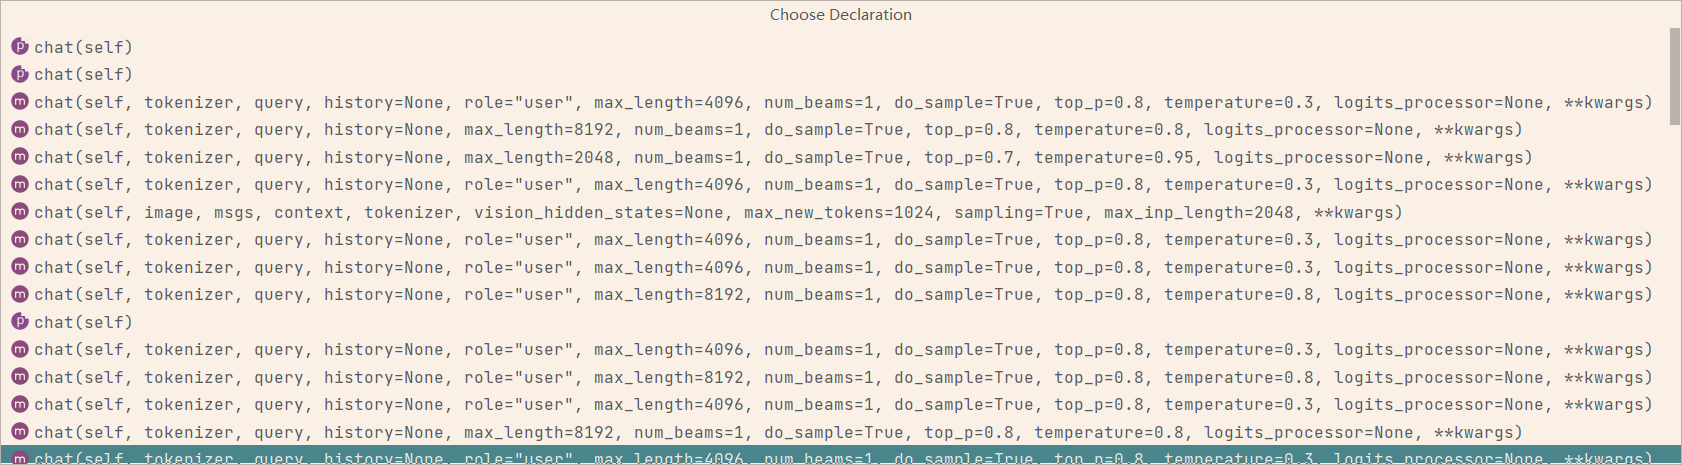
一般模型都自带了history，但是实践发现**minicpm-2B模型的chat方法不支持history**  
那么只能使用最笨的方法--**每次提问时告诉它之前发生了什么**（这样很消耗token）

In [24]:
chat_history = []
def chat_with_memory(question):
    # 将用户问题添加到历史记录
    chat_history.append({"role": "user", "content": question})
    
    # 设置提问格式
    context_question = (
        f"以下是我们之前的对话记录:\n{chat_history}\n"
        f"现在我的问题是: {question}"
    ) if chat_history else question
    
    # 获取回复并保存到历史记录
    response, history = MiniCPM.chat(tokenizer, context_question, temperature=0.8, top_p=0.8)
    chat_history.extend(history)
    
    return response

question1 = "1+1=?"
response1 = chat_with_memory(question1)
question2 = "我刚刚问了你什么"
response2 = chat_with_memory(question2)
print(question1,response1)
print(question2,response2)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


1+1=？ 1+1=2。
我刚刚问了你什么 {'role': 'assistant', 'content': '你刚刚问了我1+1等于多少。'}


可以发现**该方法还是有一定使用价值**

之前用的是`transformers`框架的api方法，现在采用的是`hugging face`框架的方法试试,也无法  

In [4]:
def generate_response(user_input):
    # 将用户输入添加到历史
    chat_history.append({"role": "user", "content": user_input})

    # 使用chat_template构建输入
    model_inputs = tokenizer.apply_chat_template(
        conversation=chat_history,
        return_tensors="pt",
        add_generation_prompt=True
    ).to('cuda')

    # 添加attention_mask
    attention_mask = torch.ones_like(model_inputs).to('cuda')
    
    # 生成回复
    model_outputs = MiniCPM.generate(
        model_inputs,
        attention_mask=attention_mask,  # 添加attention_mask
        max_new_tokens=1024,
        top_p=0.7,
        temperature=0.7,
        do_sample=True  # 启用采样以增加回复的多样性
    )

    output_token_ids = [
        model_outputs[i][len(model_inputs[i]):] for i in range(len(model_inputs))
    ]

    response = tokenizer.batch_decode(output_token_ids, skip_special_tokens=True)[0]
    chat_history.append({"role": "assistant", "content": response})

    return response

# 重置对话历史
chat_history = []

# 测试对话
question1 = "1+1=?"
response1 = generate_response(question1)
print(f"用户: {question1}")
print(f"助手: {response1}\n")

question2 = "我刚刚问了你什么？"
response2 = generate_response(question2)
print(f"用户: {question2}")
print(f"助手: {response2}")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


用户: 1+1=?
助手: 1+1=2

用户: 我刚刚问了你什么？
助手: 抱歉，我误解了你的问题。你是想问1+1=2吗？


之前发的使用`langchain`构建模型，然后可以直接调用里面的记忆功能函数。但是langchain比较适用于大语言模型，与我们端侧模型理念不符，所以弃用 
 
但是可以使用里面的方法理念，例如每次提交对话检索历史记录token值，**超过设定限额后，则后台对历史记录进行总结减少token值，这些都可以自行构造方法实现**

可能是`minicpm`模型的问题，有的时候记忆不强，且它人称有问题。例如应该回答“你刚刚问了我一加一等于几”，可是回答“我刚刚问一加一等于几”

In [ ]:
# 自己构建类，重写方法管理历史记录example
class ConversationBufferMemory:
    def __init__(self, max_tokens=2000):
        self.messages = []
        self.max_tokens = max_tokens
        
    def add_message(self, role, content):
        self.messages.append({"role": role, "content": content})
        
    def get_messages(self):
        return self.messages
    
    def clear(self):
        self.messages = []

def generate_response(user_input, memory):
    # 添加用户输入到记忆
    memory.add_message("user", user_input)
    
    # 构建模型输入
    model_inputs = tokenizer.apply_chat_template(
        memory.get_messages(),
        return_tensors="pt",
        add_generation_prompt=True
    ).to('cuda')
    
    # 生成回复
    outputs = MiniCPM.generate(
        model_inputs,
        max_new_tokens=1024,
        top_p=0.7,
        temperature=0.7
    )
    
    response = tokenizer.batch_decode(
        outputs[:, model_inputs.shape[1]:],
        skip_special_tokens=True
    )[0]
    
    # 添加助手回复到记忆
    memory.add_message("assistant", response)
    return response


**总结方法**
1. 查找有适配history参数的模型
2. 比较其他框架
3. 自己构建类，实现方法
4. 还在摸索...........


In [8]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

path = "openbmb/MiniCPM3-4B"
device = "cuda"

tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(path, torch_dtype=torch.bfloat16, device_map=device, trust_remote_code=True)

messages = [
    {"role": "user", "content": "推荐5个北京的景点。"},
]
model_inputs = tokenizer.apply_chat_template(messages, return_tensors="pt", add_generation_prompt=True).to(device)

model_outputs = model.generate(
    model_inputs,
    max_new_tokens=1024,
    top_p=0.7,
    temperature=0.7
)

output_token_ids = [
    model_outputs[i][len(model_inputs[i]):] for i in range(len(model_inputs))
]

responses = tokenizer.batch_decode(output_token_ids, skip_special_tokens=True)[0]
print(responses)


Error while downloading from https://cdn-lfs-us-1.hf.co/repos/6b/ec/6bec04b72e022a3e8e5a5d7d8b369a3c92260125345158a46a0b2330ca539844/f4c69dfe493d3b644071e1b3820d68f49bcd6674cd40e71b9e451b8534586613?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27pytorch_model.bin%3B+filename%3D%22pytorch_model.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1737271653&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczNzI3MTY1M319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzZiL2VjLzZiZWMwNGI3MmUwMjJhM2U4ZTVhNWQ3ZDhiMzY5YTNjOTIyNjAxMjUzNDUxNThhNDZhMGIyMzMwY2E1Mzk4NDQvZjRjNjlkZmU0OTNkM2I2NDQwNzFlMWIzODIwZDY4ZjQ5YmNkNjY3NGNkNDBlNzFiOWU0NTFiODUzNDU4NjYxMz9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSomcmVzcG9uc2UtY29udGVudC10eXBlPSoifV19&Signature=BfUn8OsBHCECiQCSeas9JH4M%7EhCJQA3tL4IAS9WQpF9inqjCnpmFKTO24enK9fpfQmq3%7EkFrE68oPFHMKBSJLXNUwDDuatKGOwvwG54bc5t%7E6oaacCbA65gTWhPoQzTuJYwki1JOwqYXNLHIoPgJI6EtDuiEKkJ9PAPRFJTb6u9je

北京，这座历史悠久、文化底蕴深厚的城市，拥有众多令人向往的景点。以下是五个不容错过的北京景点推荐：

1. **故宫博物院**：作为世界上现存规模最大、保存最完整的木质结构古建筑群，故宫不仅是中国明清两代皇家宫殿的象征，也是中华民族五千年文明史的缩影。漫步于紫禁城内，每一砖一瓦都透露着历史的沉淀与文化的底蕴。

2. **颐和园**：这座皇家园林以昆明湖、万寿山为基础，汇集了中国园林艺术的精华，被誉为“皇家园林博物馆”。湖光山色、亭台楼阁，每一处都透露着皇家园林的尊贵与大气，让人仿佛穿越回古代的皇家生活。

3. **天坛公园**：作为明清两代皇帝祭天祈谷的场所，天坛以其严谨的建筑布局和深厚的文化内涵著称。祈年殿的独特造型、皇穹宇的精巧构造，以及圜丘台的庄严肃穆，共同构成了天坛的独特魅力。

4. **北京动物园**：作为中国最大的城市动物园之一，北京动物园汇集了来自世界各地的珍稀动物。在这里，你可以近距离观察到国宝大熊猫、长颈鹿、斑马等动物的生活状态，体验与自然亲密接触的乐趣。

5. **天安门广场**：作为世界上最大的城市中心广场，天安门广场不仅是中国的政治中心，也是国家的象征。天安门城楼、人民英雄纪念碑、毛主席纪念堂等标志性建筑矗立于此，每天的升旗仪式和晚上的灯光秀更是吸引了无数游客前来观赏。

以上五个景点各具特色，无论是历史文化爱好者，还是自然生态探索者，都能在北京找到属于自己的精彩。希望这些建议能帮助你规划一次难忘的北京之旅！
